In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re
from pathlib import Path
import shap
from tensorflow import keras

import sys
sys.path.append('../src')

from gutatlas.models.metrics import plot_pred_scatter, regression_metrics, plot_shap_importance
from gutatlas.models.xgboost import XGBRegTuner

from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    train_test_split,
    cross_val_score,
)
from skopt import BayesSearchCV
from skopt.space import Integer, Real
import xgboost as xgb

In [2]:
bmi_training = pd.read_parquet('../data/processed/bmi_training.parquet')

X = bmi_training.iloc[:,:-1]
y = bmi_training.iloc[:,-1]

X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42)

<Axes: ylabel='Frequency'>

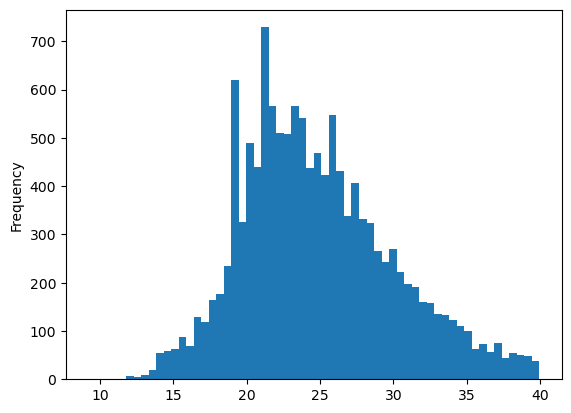

In [3]:
y.plot(kind='hist', bins = 60)

## XGBoost

In [4]:
tuner = XGBRegTuner(cv_splits=2, n_iter=1, n_jobs=-1)

tuner.fit(X_train,y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


In [5]:
tuner.best_params(),tuner.best_score()


(OrderedDict([('colsample_bytree', 0.6305568678607113),
              ('learning_rate', 0.0017872133434394676),
              ('max_depth', 8),
              ('n_estimators', 707),
              ('reg_alpha', 0.058244733061701456),
              ('reg_lambda', 0.003178874814167418),
              ('subsample', 0.907357391915923)]),
 np.float64(-21.96388149425515))

In [8]:
tuner.save_model('../saved_models','bmi_regression_xgboost_model.json')
tuner.save_params('../params','bmi_regression_xgboost_params.json')

In [9]:
best_model = xgb.XGBRegressor()
best_model.load_model('../saved_models/bmi_regression_xgboost_model.json')

y_pred = best_model.predict(X_test)

regression_metrics(y_test,y_pred)


{'mse': 17.283222575790113,
 'rmse': np.float64(4.157309535720201),
 'mae': 3.189225273769878}

In [10]:
plot_pred_scatter(y_test,y_pred)


/opt/anaconda3/envs/gutatlas/lib/python3.10/site-packages/shap/plots/_beeswarm.py:1150: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



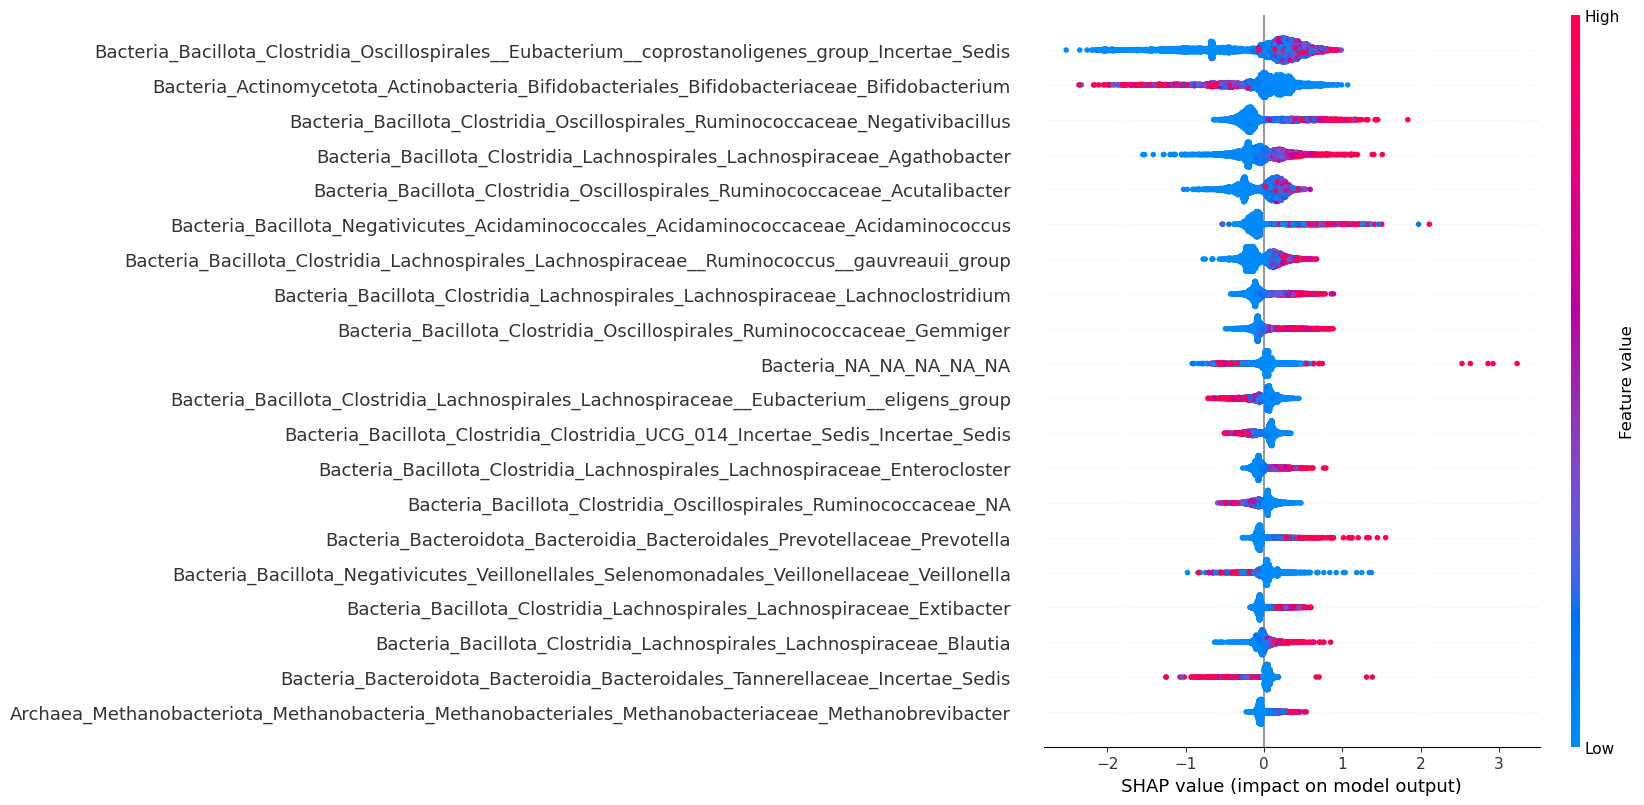

In [10]:
plot_shap_importance(best_model,X_test)

## neural net

In [16]:
model = keras.Sequential([
    keras.layers.Input((X_train.shape[1],)),
    #keras.layers.Dense(512,activation='relu'),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(1)
])

model.compile(
    loss='mse',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

history = model.fit(
    X_train,
    y_train,
    epochs=40,
    batch_size=1028,
    validation_split=0.1,
    verbose = 1
)

loss_fig = go.Figure()

loss_fig.add_trace(
    go.Scatter(
        x=history.epoch,
        y=history.history['loss'],
        mode='lines',
        name='loss',
    )
)

loss_fig.add_trace(
    go.Scatter(
        x=history.epoch,
        y=history.history['val_loss'],
        mode='lines',
        name='val_loss',
    )
)

loss_fig.update_layout(
    title='training loss',
    xaxis_title='epoch',
    yaxis_title='mse',
)

Epoch 1/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 635.1608 - mae: 24.6603 - val_loss: 615.3403 - val_mae: 24.2989
Epoch 2/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 599.9756 - mae: 23.9347 - val_loss: 569.8019 - val_mae: 23.3433
Epoch 3/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 545.3240 - mae: 22.7624 - val_loss: 502.0286 - val_mae: 21.8436
Epoch 4/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 467.7663 - mae: 20.9843 - val_loss: 411.0333 - val_mae: 19.6509
Epoch 5/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 368.0021 - mae: 18.4487 - val_loss: 300.8751 - val_mae: 16.6136
Epoch 6/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 253.7859 - mae: 15.0216 - val_loss: 184.7287 - val_mae: 12.6444
Epoch 7/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 142.9458 - mae: 10.7136 - val_loss: 86.9278 - val_mae: 7.9796
Epoch 8/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 62.4463 - mae: 6.2797 - val_loss: 33.5699 - val_mae: 4.4120
Epoch 9/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s

In [12]:
nn_preds = model.predict(X_test)
print('RMSE:',np.sqrt(mean_squared_error(y_test,nn_preds)),'MAE:',mean_absolute_error(y_test,nn_preds))

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step
RMSE: 4.796793626463746 MAE: 3.82425327551173


In [13]:
pred_scatter = px.scatter(
    x=y_test,
    y=nn_preds[:,0],
    labels={'x': 'True BMI', 'y': 'Predicted BMI'},
)

identity = go.Scatter(
    x=np.linspace(min(y_test.min(), nn_preds.min()), max(y_test.max(), nn_preds.max()), 100),
    y=np.linspace(min(y_test.min(), nn_preds.min()), max(y_test.max(), nn_preds.max()), 100),
    mode="lines",
    line=dict(color="red", dash="dash"),
    name="y = x",
)

pred_scatter.add_trace(identity)
pred_scatter.update_traces(marker=dict(size=5, opacity=0.1))
pred_scatter.show()
